In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
# Import Library
from keras.models import Model
from keras.layers import Input, MaxPooling2D, Dense, Dropout, Add, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers import ReLU, ELU
import keras.backend as K
import warnings
warnings.filterwarnings('ignore')


# Model
class Network(object):
    def __init__(self):
    # Data Size
    # Input Image
        self.INPUT_IMAGE_SIZE1 = 138 # 138
        self.INPUT_IMAGE_SIZE2 = 151 # 151
    # Input Volume
        self.INPUT_CHANNEL_2 = 3 # 3
    # Input MU
        self.INPUT_CHANNEL_3 = 7 # 7
    # Output Channel
        self.OUTPUT_CHANNEL = 1

## Model Architecture ( https://doi.org/10.1002/mp.13112 ) ##
    
    # Inputs
        input1 = Input([self.INPUT_IMAGE_SIZE1, self.INPUT_IMAGE_SIZE2, 1], name="input_1")
        input2 = Input([self.INPUT_CHANNEL_2, 1], name="input_2")
        input3 = Input([self.INPUT_CHANNEL_3, 1], name="input_3")
    
    # Path_1
        h1 = Conv2D(filters=8, kernel_size=(7,7), strides=(2,2), padding="valid")(input1)
        h1 = ELU()(h1)
        h1 = MaxPooling2D(pool_size=(1,3), strides=(1,3), padding="valid")(h1)
        h1 = Conv2D(filters=8, kernel_size=(5,5), strides=(1,1), padding="valid")(h1)
        h1 = ReLU()(h1)
        h1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(h1)
        h1 = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding="valid")(h1)
        h1 = ReLU()(h1)
        h1 = MaxPooling2D(pool_size=(4,2), strides=(4,2), padding="valid")(h1)
        h1 = Dropout(rate=0.25)(h1)
        h1 = Flatten()(h1)
        h1 = Dense(units=20)(h1)
    
    # Path_2
        h2 = Flatten()(input2)
        h2 = Dense(units=20)(h2)
        h2 = Dropout(rate=0.25)(h2)
        h2 = Dense(units=20)(h2)
    
    # Path_3
        h3 = Flatten()(input3)
        h3 = Dense(units=20)(h3)
        h3 = Dropout(rate=0.25)(h3)
        h3 = Dense(units=20)(h3)

    # Concate
        h = Add()([h1, h2, h3])
    
    # Outputs
        output1 = Dense(units=self.OUTPUT_CHANNEL)(h)
        output2 = Dense(units=self.OUTPUT_CHANNEL)(h)
        output3 = Dense(units=self.OUTPUT_CHANNEL)(h)
        output4 = Dense(units=self.OUTPUT_CHANNEL)(h)
    
    # Model
        self.Network = Model(input=[input1, input2, input3], outputs=[output1, output2, output3, output4])
    
    def get_model(self):
        return self.Network
    

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________________________________________
Layer (type)                              Output Shape                 Param #         Connected to                               
input_1 (InputLayer)                      (None, 138, 151, 1)          0                                                          
__________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                         (None, 66, 73, 8)            400             input_1[0][0]                              
__________________________________________________________________________________________________________________________________
elu_1 (ELU)                               (None, 66, 73, 8)            0     

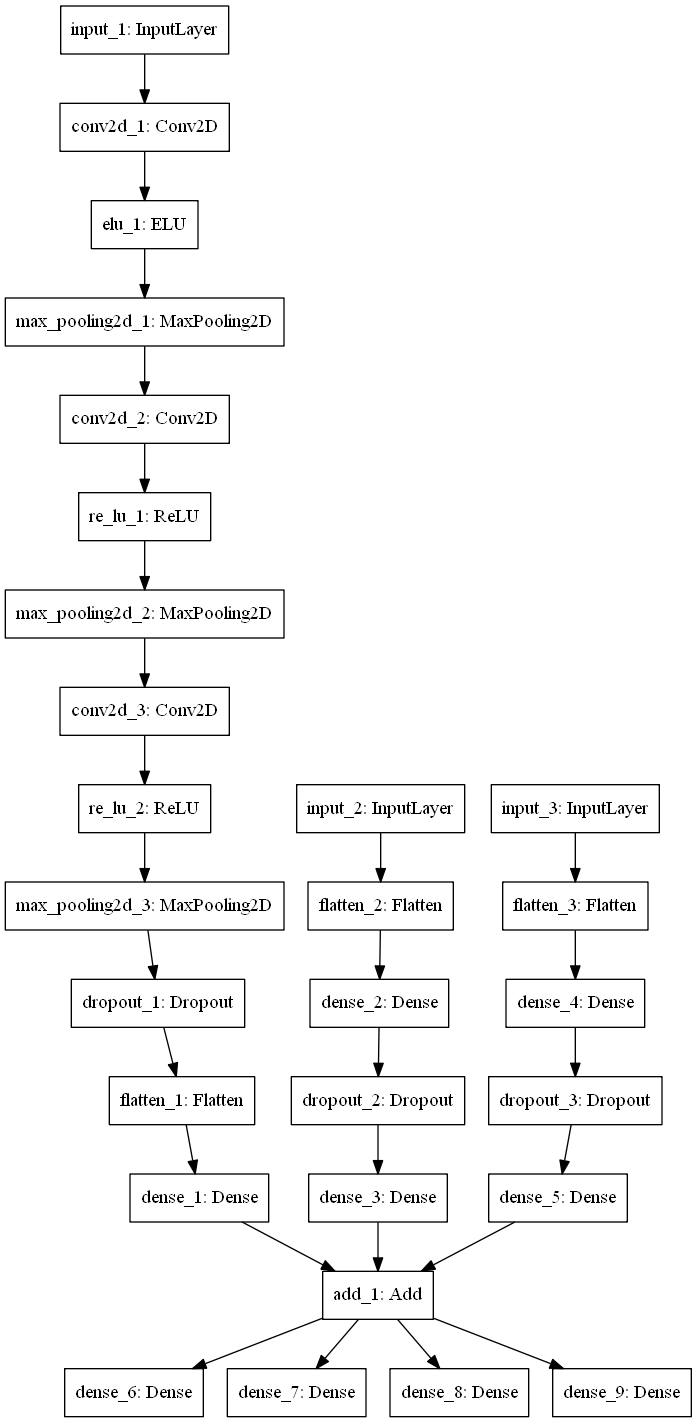

In [3]:
## Load Model Architecture ##
import tensorflow as tf

# Import Library
from keras.optimizers import Adam
from keras.losses import mean_squared_error
import keras.backend as K
from keras.utils import plot_model

# Huber Loss
def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)

# Compile model
network = Network()
model = network.get_model()
model.compile(optimizer=Adam(), loss=huber_loss, loss_weights=[1., 1., 1., 1.])

# Model summary
model.summary(line_length=130)
plot_model(model, to_file='model.png') # graphviz の Install が必要なため，適宜コメントアウトして下さい．

In [4]:
## Load Dataset ##　#　変更なし　#

# Import
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import glob
import os

# Volume, MU
VolumeMUFile = r"XX.csv" # Volume, MU が格納された 学習用 csv file
VolumeMU = pd.read_csv(VolumeMUFile, sep=",", header=0)
Volume = DataFrame(VolumeMU.drop(["MU01", "MU02", "MU03", "MU04", "MU05", "MU06", "MU07"], axis=1)).astype(np.float).to_numpy()
Volume = Volume.reshape([len(Volume), 3, 1])
MU = DataFrame(VolumeMU.drop(["PTV", "Rectum", "OV"], axis=1)).astype(np.float).to_numpy()
MU = MU.reshape(len(MU), 7, 1)

# Images
Dosefolder = r"XX" # 学習用 dose folder
folders = glob.glob(os.path.join(Dosefolder, "*.csv"))
Dose = np.zeros([len(folders), 138, 151, 1])
for i, folder in enumerate(folders):
    data = pd.read_csv(folder, header=None).astype(np.float).to_numpy()
    data = data.reshape([1, 138, 151, 1])
    Dose[i] = data

# Inputs     
x_train = [Dose, Volume, MU]

# Outputs
GPRFile = r"XX.csv" # 答えとなる学習用 GPR が格納された csv file
GPR = pd.read_csv(GPRFile, sep=",", header=0).astype(np.float).to_numpy()
y_train = [GPR[:,0], GPR[:,1], GPR[:,2], GPR[:,3]]


In [5]:
## Train Model ##

from keras.callbacks import ModelCheckpoint, CSVLogger

saveWeightPath = r"XX" # weight を保存する folder
saveWeight = os.path.join(saveWeightPath, 'weights.{epoch:002d}-{val_loss:2f}.hdf5')
saveLogFile = r"XX.csv" # log を保存する csv file
cb_mc = ModelCheckpoint(saveWeight, period=1)
cb_log = CSVLogger(saveLogFile, separator=',', append=True)
history = model.fit(x_train, y_train, batch_size=1, epochs=500, validation_data=[x_train, y_train], verbose=1, callbacks=[cb_mc, cb_log])

Train on 40 samples, validate on 40 samples
Epoch 1/500
40/40 [==============================] - 4s 112ms/step - loss: 269.7296 - dense_6_loss: 97.1360 - dense_7_loss: 58.1397 - dense_8_loss: 56.7325 - dense_9_loss: 57.7215 - val_loss: 61.9621 - val_dense_6_loss: 16.3501 - val_dense_7_loss: 16.2832 - val_dense_8_loss: 15.0408 - val_dense_9_loss: 14.2881
Epoch 2/500
40/40 [==============================] - 1s 17ms/step - loss: 174.9533 - dense_6_loss: 40.9359 - dense_7_loss: 51.1361 - dense_8_loss: 39.9530 - dense_9_loss: 42.9283 - val_loss: 61.6648 - val_dense_6_loss: 14.0080 - val_dense_7_loss: 13.2434 - val_dense_8_loss: 17.5334 - val_dense_9_loss: 16.8799
Epoch 3/500
40/40 [==============================] - 1s 20ms/step - loss: 140.2373 - dense_6_loss: 32.4316 - dense_7_loss: 40.6074 - dense_8_loss: 30.3239 - dense_9_loss: 36.8744 - val_loss: 66.4649 - val_dense_6_loss: 12.6040 - val_dense_7_loss: 24.6928 - val_dense_8_loss: 14.5771 - val_dense_9_loss: 14.5911
Epoch 4/500
40/40 [===

Epoch 54/500
40/40 [==============================] - 1s 16ms/step - loss: 23.8989 - dense_6_loss: 6.3617 - dense_7_loss: 5.7765 - dense_8_loss: 6.2301 - dense_9_loss: 5.5306 - val_loss: 15.1569 - val_dense_6_loss: 3.1830 - val_dense_7_loss: 5.1337 - val_dense_8_loss: 3.5139 - val_dense_9_loss: 3.3263
Epoch 55/500
40/40 [==============================] - 1s 15ms/step - loss: 30.0383 - dense_6_loss: 6.4211 - dense_7_loss: 7.9587 - dense_8_loss: 7.5376 - dense_9_loss: 8.1210 - val_loss: 12.0692 - val_dense_6_loss: 2.8169 - val_dense_7_loss: 3.2341 - val_dense_8_loss: 3.3339 - val_dense_9_loss: 2.6842
Epoch 56/500
40/40 [==============================] - 1s 15ms/step - loss: 27.9212 - dense_6_loss: 6.7785 - dense_7_loss: 6.9448 - dense_8_loss: 6.8161 - dense_9_loss: 7.3818 - val_loss: 13.7721 - val_dense_6_loss: 3.6572 - val_dense_7_loss: 4.2715 - val_dense_8_loss: 3.0854 - val_dense_9_loss: 2.7579
Epoch 57/500
40/40 [==============================] - 1s 17ms/step - loss: 26.6035 - dense_

40/40 [==============================] - 0s 12ms/step - loss: 21.5150 - dense_6_loss: 5.3052 - dense_7_loss: 5.5895 - dense_8_loss: 5.8614 - dense_9_loss: 4.7589 - val_loss: 8.9084 - val_dense_6_loss: 3.3449 - val_dense_7_loss: 2.3740 - val_dense_8_loss: 1.4417 - val_dense_9_loss: 1.7478
Epoch 82/500
40/40 [==============================] - 1s 15ms/step - loss: 25.5979 - dense_6_loss: 6.2183 - dense_7_loss: 6.6977 - dense_8_loss: 6.3741 - dense_9_loss: 6.3078 - val_loss: 13.2635 - val_dense_6_loss: 2.0428 - val_dense_7_loss: 5.3138 - val_dense_8_loss: 3.3302 - val_dense_9_loss: 2.5768
Epoch 83/500
40/40 [==============================] - 1s 21ms/step - loss: 20.4814 - dense_6_loss: 4.5690 - dense_7_loss: 4.8605 - dense_8_loss: 6.0060 - dense_9_loss: 5.0460 - val_loss: 20.2897 - val_dense_6_loss: 3.5491 - val_dense_7_loss: 5.9984 - val_dense_8_loss: 6.5405 - val_dense_9_loss: 4.2017
Epoch 84/500
40/40 [==============================] - 1s 14ms/step - loss: 26.0832 - dense_6_loss: 6.3875

40/40 [==============================] - 0s 12ms/step - loss: 16.7237 - dense_6_loss: 3.8865 - dense_7_loss: 4.2508 - dense_8_loss: 4.4293 - dense_9_loss: 4.1571 - val_loss: 9.4937 - val_dense_6_loss: 2.6593 - val_dense_7_loss: 3.8221 - val_dense_8_loss: 0.9009 - val_dense_9_loss: 2.1113
Epoch 136/500
40/40 [==============================] - 0s 12ms/step - loss: 16.7122 - dense_6_loss: 3.6423 - dense_7_loss: 3.9325 - dense_8_loss: 4.1249 - dense_9_loss: 5.0124 - val_loss: 19.8561 - val_dense_6_loss: 4.7486 - val_dense_7_loss: 4.9421 - val_dense_8_loss: 4.4887 - val_dense_9_loss: 5.6768
Epoch 137/500
40/40 [==============================] - 1s 14ms/step - loss: 12.5495 - dense_6_loss: 2.8024 - dense_7_loss: 2.9735 - dense_8_loss: 3.1408 - dense_9_loss: 3.6328 - val_loss: 4.5409 - val_dense_6_loss: 1.6369 - val_dense_7_loss: 1.0407 - val_dense_8_loss: 0.9242 - val_dense_9_loss: 0.9392
Epoch 138/500
40/40 [==============================] - 0s 12ms/step - loss: 18.1239 - dense_6_loss: 4.56

40/40 [==============================] - 1s 16ms/step - loss: 14.9321 - dense_6_loss: 3.0064 - dense_7_loss: 3.9969 - dense_8_loss: 4.1506 - dense_9_loss: 3.7781 - val_loss: 8.8653 - val_dense_6_loss: 2.5881 - val_dense_7_loss: 2.4416 - val_dense_8_loss: 1.6903 - val_dense_9_loss: 2.1453
Epoch 190/500
40/40 [==============================] - 1s 15ms/step - loss: 18.9181 - dense_6_loss: 4.7503 - dense_7_loss: 5.0473 - dense_8_loss: 4.3188 - dense_9_loss: 4.8016 - val_loss: 8.5858 - val_dense_6_loss: 1.8442 - val_dense_7_loss: 3.5132 - val_dense_8_loss: 1.9166 - val_dense_9_loss: 1.3118
Epoch 191/500
40/40 [==============================] - 1s 19ms/step - loss: 17.7266 - dense_6_loss: 4.3815 - dense_7_loss: 4.7181 - dense_8_loss: 4.4984 - dense_9_loss: 4.1286 - val_loss: 13.9420 - val_dense_6_loss: 4.1871 - val_dense_7_loss: 4.3254 - val_dense_8_loss: 2.7087 - val_dense_9_loss: 2.7209
Epoch 192/500
40/40 [==============================] - 1s 15ms/step - loss: 19.5751 - dense_6_loss: 4.66

40/40 [==============================] - 1s 14ms/step - loss: 15.4372 - dense_6_loss: 3.5438 - dense_7_loss: 3.9743 - dense_8_loss: 3.9956 - dense_9_loss: 3.9235 - val_loss: 5.4300 - val_dense_6_loss: 1.7270 - val_dense_7_loss: 1.0640 - val_dense_8_loss: 1.6651 - val_dense_9_loss: 0.9740
Epoch 217/500
40/40 [==============================] - 1s 15ms/step - loss: 14.5672 - dense_6_loss: 3.6886 - dense_7_loss: 3.9604 - dense_8_loss: 3.3469 - dense_9_loss: 3.5712 - val_loss: 16.2599 - val_dense_6_loss: 5.4078 - val_dense_7_loss: 4.9325 - val_dense_8_loss: 2.8574 - val_dense_9_loss: 3.0623
Epoch 218/500
40/40 [==============================] - 1s 16ms/step - loss: 14.3235 - dense_6_loss: 3.8819 - dense_7_loss: 3.6341 - dense_8_loss: 3.3736 - dense_9_loss: 3.4339 - val_loss: 5.2829 - val_dense_6_loss: 1.4728 - val_dense_7_loss: 1.0087 - val_dense_8_loss: 1.8312 - val_dense_9_loss: 0.9702
Epoch 219/500
40/40 [==============================] - 1s 13ms/step - loss: 11.5248 - dense_6_loss: 2.74

40/40 [==============================] - 0s 11ms/step - loss: 18.0370 - dense_6_loss: 4.4545 - dense_7_loss: 4.6236 - dense_8_loss: 4.5566 - dense_9_loss: 4.4023 - val_loss: 5.7424 - val_dense_6_loss: 1.7168 - val_dense_7_loss: 1.0389 - val_dense_8_loss: 2.2858 - val_dense_9_loss: 0.7009
Epoch 271/500
40/40 [==============================] - 1s 13ms/step - loss: 19.6241 - dense_6_loss: 4.3875 - dense_7_loss: 5.2456 - dense_8_loss: 5.1232 - dense_9_loss: 4.8677 - val_loss: 8.8914 - val_dense_6_loss: 3.1308 - val_dense_7_loss: 2.3983 - val_dense_8_loss: 1.7001 - val_dense_9_loss: 1.6622
Epoch 272/500
40/40 [==============================] - 1s 16ms/step - loss: 14.3798 - dense_6_loss: 3.7832 - dense_7_loss: 3.6502 - dense_8_loss: 3.4649 - dense_9_loss: 3.4815 - val_loss: 6.2644 - val_dense_6_loss: 1.5237 - val_dense_7_loss: 1.1514 - val_dense_8_loss: 1.1649 - val_dense_9_loss: 2.4244
Epoch 273/500
40/40 [==============================] - 1s 15ms/step - loss: 13.3646 - dense_6_loss: 3.317

40/40 [==============================] - 1s 13ms/step - loss: 13.0531 - dense_6_loss: 3.0427 - dense_7_loss: 3.6766 - dense_8_loss: 3.4315 - dense_9_loss: 2.9023 - val_loss: 5.9502 - val_dense_6_loss: 1.2855 - val_dense_7_loss: 1.6835 - val_dense_8_loss: 2.3685 - val_dense_9_loss: 0.6127
Epoch 325/500
40/40 [==============================] - 1s 16ms/step - loss: 18.2783 - dense_6_loss: 4.3295 - dense_7_loss: 4.9722 - dense_8_loss: 4.5374 - dense_9_loss: 4.4391 - val_loss: 14.7666 - val_dense_6_loss: 2.7435 - val_dense_7_loss: 3.3022 - val_dense_8_loss: 3.6414 - val_dense_9_loss: 5.0795
Epoch 326/500
40/40 [==============================] - 1s 18ms/step - loss: 15.6316 - dense_6_loss: 3.4134 - dense_7_loss: 3.9043 - dense_8_loss: 3.9535 - dense_9_loss: 4.3603 - val_loss: 21.4232 - val_dense_6_loss: 4.6499 - val_dense_7_loss: 5.6408 - val_dense_8_loss: 5.2183 - val_dense_9_loss: 5.9142
Epoch 327/500
40/40 [==============================] - 1s 18ms/step - loss: 16.7919 - dense_6_loss: 4.0

40/40 [==============================] - 1s 17ms/step - loss: 14.2557 - dense_6_loss: 3.7190 - dense_7_loss: 3.3807 - dense_8_loss: 3.5680 - dense_9_loss: 3.5880 - val_loss: 14.5617 - val_dense_6_loss: 3.4337 - val_dense_7_loss: 3.2117 - val_dense_8_loss: 2.7453 - val_dense_9_loss: 5.1709
Epoch 379/500
40/40 [==============================] - 0s 12ms/step - loss: 13.3028 - dense_6_loss: 3.1960 - dense_7_loss: 3.3937 - dense_8_loss: 3.2700 - dense_9_loss: 3.4430 - val_loss: 11.5611 - val_dense_6_loss: 2.6133 - val_dense_7_loss: 3.7567 - val_dense_8_loss: 2.1044 - val_dense_9_loss: 3.0867
Epoch 380/500
40/40 [==============================] - 1s 16ms/step - loss: 14.6636 - dense_6_loss: 3.6603 - dense_7_loss: 3.7170 - dense_8_loss: 3.2966 - dense_9_loss: 3.9897 - val_loss: 5.1396 - val_dense_6_loss: 2.0507 - val_dense_7_loss: 0.8418 - val_dense_8_loss: 1.4380 - val_dense_9_loss: 0.8092
Epoch 381/500
40/40 [==============================] - 1s 13ms/step - loss: 14.3505 - dense_6_loss: 3.6

40/40 [==============================] - 1s 13ms/step - loss: 17.9191 - dense_6_loss: 4.0200 - dense_7_loss: 4.3537 - dense_8_loss: 4.3845 - dense_9_loss: 5.1610 - val_loss: 5.6893 - val_dense_6_loss: 1.8101 - val_dense_7_loss: 1.0604 - val_dense_8_loss: 0.6528 - val_dense_9_loss: 2.1660
Epoch 433/500
40/40 [==============================] - 0s 12ms/step - loss: 15.0752 - dense_6_loss: 3.7464 - dense_7_loss: 3.7752 - dense_8_loss: 3.6605 - dense_9_loss: 3.8931 - val_loss: 4.5809 - val_dense_6_loss: 1.5135 - val_dense_7_loss: 1.9157 - val_dense_8_loss: 0.6425 - val_dense_9_loss: 0.5091
Epoch 434/500
40/40 [==============================] - 0s 12ms/step - loss: 14.7037 - dense_6_loss: 3.8152 - dense_7_loss: 3.6195 - dense_8_loss: 3.5344 - dense_9_loss: 3.7346 - val_loss: 5.0944 - val_dense_6_loss: 1.4138 - val_dense_7_loss: 1.5027 - val_dense_8_loss: 1.1404 - val_dense_9_loss: 1.0375
Epoch 435/500
40/40 [==============================] - 1s 17ms/step - loss: 13.3225 - dense_6_loss: 3.059

40/40 [==============================] - 0s 11ms/step - loss: 14.2206 - dense_6_loss: 3.6950 - dense_7_loss: 3.4970 - dense_8_loss: 3.4993 - dense_9_loss: 3.5293 - val_loss: 6.0212 - val_dense_6_loss: 1.4723 - val_dense_7_loss: 1.1966 - val_dense_8_loss: 0.8728 - val_dense_9_loss: 2.4794
Epoch 487/500
40/40 [==============================] - 0s 12ms/step - loss: 13.4553 - dense_6_loss: 3.2928 - dense_7_loss: 3.5401 - dense_8_loss: 3.2090 - dense_9_loss: 3.4133 - val_loss: 4.9406 - val_dense_6_loss: 1.3271 - val_dense_7_loss: 0.9190 - val_dense_8_loss: 1.5250 - val_dense_9_loss: 1.1694
Epoch 488/500
40/40 [==============================] - 1s 22ms/step - loss: 14.8714 - dense_6_loss: 3.5300 - dense_7_loss: 3.7787 - dense_8_loss: 3.7798 - dense_9_loss: 3.7829 - val_loss: 12.9837 - val_dense_6_loss: 2.9098 - val_dense_7_loss: 3.9950 - val_dense_8_loss: 2.8301 - val_dense_9_loss: 3.2488
Epoch 489/500
40/40 [==============================] - 1s 13ms/step - loss: 13.6971 - dense_6_loss: 3.57

In [6]:
## Predict Model ##

from keras.models import load_model

# Volume, MU
VolumeMUFile = r"XX.csv" # Volume, MU が格納された テスト用 csv file
VolumeMU = pd.read_csv(VolumeMUFile, sep=",", header=0)
Volume = DataFrame(VolumeMU.drop(["MU01", "MU02", "MU03", "MU04", "MU05", "MU06", "MU07"], axis=1)).astype(np.float).to_numpy()
Volume = Volume.reshape([len(Volume), 3, 1])
MU = DataFrame(VolumeMU.drop(["PTV", "Rectum", "OV"], axis=1)).astype(np.float).to_numpy()
MU = MU.reshape(len(MU), 7, 1)

# Images
Dosefolder = r"XX" # テスト用 dose folder
folders = glob.glob(os.path.join(Dosefolder, "*.csv"))
Dose = np.zeros([len(folders), 138, 151, 1])
for i, folder in enumerate(folders):
    data = pd.read_csv(folder, header=None).astype(np.float).to_numpy()
    data = data.reshape([1, 138, 151, 1])
    Dose[i] = data

# Inputs     
x_test = [Dose, Volume, MU]

# Outputs
GPRFile = r"XX.csv" # テスト用 GPR が格納された csv file
GPR = pd.read_csv(GPRFile, sep=",", header=0).astype(np.float).to_numpy()
y_test = [GPR[:,0], GPR[:,1], GPR[:,2], GPR[:,3]]

# Predict
model = load_model(r"XX.hdf5") # テストに使う weight を選択
y_pred = model.predict(x_test)